In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1012. NC Well Arsenic/P1012.2. Analyses/P1012.2.3. ML Visualizations//Output')
cur_date = "052423"

library(readxl)
library(lubridate)
library(tidyverse)
library(randomForest)
library(MetBrewer)
library(e1071)
library(themis)

#reading in files
well_data = data.frame(read_excel("Input/Imputed_Well_Data_051023.xlsx")) 


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr   1.1.2     ✔ readr   2.1.4
✔ forcats 1.0.0     ✔ stringr 1.5.0
✔ ggplot2 3.4.2     ✔ tibble  3.2.1
✔ purrr   1.0.1     ✔ tidyr   1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: recipes


Attaching package: ‘recipes’


The following object is masked from ‘package:stringr’:

    fixed


The

In [2]:
head(well_data)

,Tax_ID,Health_Dept_ID,Permit_No,Water_Sample_Date,Casing_Depth,Well_Depth,Static_Water_Depth,Flow_Rate,pH,Metal,Concentration,Detect_Concentration
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,1006004,960,12-155,9/24/12,52,165,41,60.0,7.7,Ar,1.438029,ND
2,1024009,1803,15-177,12/17/15,40,445,42,2.0,7.3,Ar,1.863054,ND
3,1054019,1647,14-212,2/2/15,45,160,40,40.0,7.4,Ar,1.434020,ND
4,1057017,970,12-169,10/22/12,42,440,57,1.5,8.0,Ar,35.000000,D
5,1060006,533,10-239,1/3/11,48,120,42,25.0,7.1,Ar,1.470804,ND
6,1066006,1795,15-224,12/15/15,60,280,32,10.0,8.2,Ar,53.000000,D


In supervised machine learning, decision boundaries help assess how well two predictors (on the x and y axis) separate different classes in classification. A clear decision boundary has most classes well separated.

In [3]:
arsenic_data = well_data %>%
    mutate(Five_Threshold = relevel(factor(ifelse(Concentration >= 5, 1, 0)), ref = "0"),
          Ten_Threshold = relevel(factor(ifelse(Concentration >= 10, 1, 0)), ref = "0"),
           # making this col into a factor
          Detect_Concentration = relevel(factor(ifelse(Detect_Concentration == "D", 1, 0)), ref = "0"),
          # converting water sample date from a character to a date type
          Water_Sample_Date = mdy(Water_Sample_Date)) %>%

    # filtering for Arsenic only
    filter(Metal == "Ar")


head(arsenic_data)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Water_Sample_Date = mdy(Water_Sample_Date)`.
Caused by warning:
!  9 failed to parse.”


,Tax_ID,Health_Dept_ID,Permit_No,Water_Sample_Date,Casing_Depth,Well_Depth,Static_Water_Depth,Flow_Rate,pH,Metal,Concentration,Detect_Concentration,Five_Threshold,Ten_Threshold
,<chr>,<dbl>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<fct>,<fct>
1,1006004,960,12-155,2012-09-24,52,165,41,60.0,7.7,Ar,1.438029,0,0,0
2,1024009,1803,15-177,2015-12-17,40,445,42,2.0,7.3,Ar,1.863054,0,0,0
3,1054019,1647,14-212,2015-02-02,45,160,40,40.0,7.4,Ar,1.434020,0,0,0
4,1057017,970,12-169,2012-10-22,42,440,57,1.5,8.0,Ar,35.000000,1,1,1
5,1060006,533,10-239,2011-01-03,48,120,42,25.0,7.1,Ar,1.470804,0,0,0
6,1066006,1795,15-224,2015-12-15,60,280,32,10.0,8.2,Ar,53.000000,1,1,1


In [4]:
# creating dfs for each outcome
# dropped 3 rows that had missing dates
arsenic_detect_df = drop_na(arsenic_data[,c(4:9,12)])  
arsenic_five_df = drop_na(arsenic_data[,c(4:9,13)]) 
arsenic_ten_df = drop_na(arsenic_data[,c(4:9,14)])

head(arsenic_detect_df)

,Water_Sample_Date,Casing_Depth,Well_Depth,Static_Water_Depth,Flow_Rate,pH,Detect_Concentration
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,2012-09-24,52,165,41,60.0,7.7,0
2,2015-12-17,40,445,42,2.0,7.3,0
3,2015-02-02,45,160,40,40.0,7.4,0
4,2012-10-22,42,440,57,1.5,8.0,1
5,2011-01-03,48,120,42,25.0,7.1,0
6,2015-12-15,60,280,32,10.0,8.2,1


# Decision Boundary Calculation

In [5]:
# creating a df with variables that we're interested in 
# creating 2 plots: the first based on the highest predictivity and highest ranking var for that model
# the 2nd: will consist of var that consistently ranked the highest (ie. pH and flow rate)
highest_predictivity_data = data.frame(arsenic_ten_df[,c("Static_Water_Depth", "Casing_Depth", "Ten_Threshold")])
consistent_variables_data = data.frame(arsenic_ten_df[,c("pH", "Flow_Rate", "Ten_Threshold")])

# using smote first to balance classes
balanced_highest_pred_data = smotenc(highest_predictivity_data, "Ten_Threshold")
balanced_consistent_var_data = smotenc(consistent_variables_data, "Ten_Threshold")

# predicting
svm_detect_arsenic = svm(Ten_Threshold~., data = balanced_highest_pred_data, kernel = "radial")
rf_detect_arsenic = randomForest(Ten_Threshold~., data = balanced_consistent_var_data)

In [6]:
# obtaining grid values and predictions visualize using ggplot
get_grid_df <- function(model, data, class = NULL, predict_type = "class",
  resolution = 100, showgrid = TRUE, ...) {

  # plotting original data
  if(!is.null(class)) cl <- data[,class] else cl <- 1
  data <- data[,1:2]
  k <- length(unique(cl))

  # make grid (between min and max for each variable)
  r <- sapply(data, range, na.rm = TRUE)
  xs <- seq(r[1,1], r[2,1], length.out = resolution)
  ys <- seq(r[1,2], r[2,2], length.out = resolution)
  g <- cbind(rep(xs, each=resolution), rep(ys, time = resolution))
  colnames(g) <- colnames(r)
  g <- as.data.frame(g)
    
  ### guess how to get class labels from predict
  ### (unfortunately not very consistent between models)
  p <- predict(model, g, type = predict_type)
  g$Pred_Class = p
    
  return(g)
}

# calling function
grid_df_svm = get_grid_df(svm_detect_arsenic, balanced_highest_pred_data, class = "Ten_Threshold")
grid_df_rf = get_grid_df(rf_detect_arsenic, balanced_consistent_var_data, class = "Ten_Threshold")
head(grid_df_svm)

,Static_Water_Depth,Casing_Depth,Pred_Class
,<dbl>,<dbl>,<fct>
1,1,22.00000,0
2,1,23.81818,0
3,1,25.63636,0
4,1,27.45455,0
5,1,29.27273,0
6,1,31.09091,0


# Decision Boundary Plot

In [7]:
colnames(arsenic_ten_df)

[1] "Water_Sample_Date"  "Casing_Depth"       "Well_Depth"        
[4] "Static_Water_Depth" "Flow_Rate"          "pH"                
[7] "Ten_Threshold"

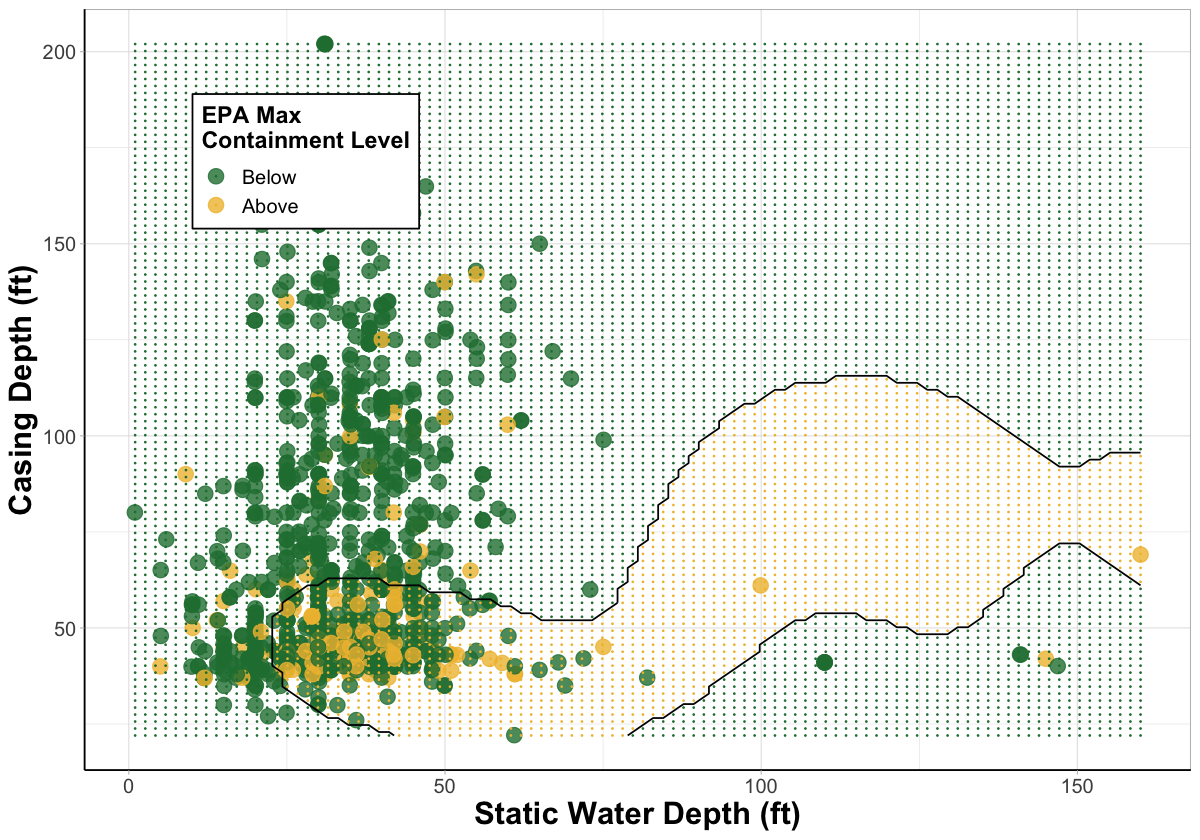

In [8]:
options(repr.plot.width=10, repr.plot.height=7) #changing size

#choosing palette from package
metbrewer_colors = MetPalettes$Lakota[[1]]

ggplot() +
  geom_point(data = arsenic_ten_df, aes(x = Static_Water_Depth, y = Casing_Depth, color = Ten_Threshold),
            position = position_jitter(w = 0.1, h = 0.1), size = 4, alpha = 0.8) + 
  geom_contour(data = grid_df_svm, aes(x = Static_Water_Depth, y = Casing_Depth, z = as.numeric(Pred_Class == "1")), 
               color = "black", breaks = 0.5) + #adds contour line
  geom_point(data = grid_df_svm, aes(x = Static_Water_Depth, y = Casing_Depth, color = Pred_Class), 
             size = 0.1) + #shades plot

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = c(0.2,0.8), # move legend to top left corner
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  labs(x = 'Static Water Depth (ft)', y = 'Casing Depth (ft)') + #changing axis labels 

  scale_color_manual(name = "EPA Max\nContainment Level",
                      values = c(metbrewer_colors[5], metbrewer_colors[2]),
                      labels = c('Below','Above'))  #reordering

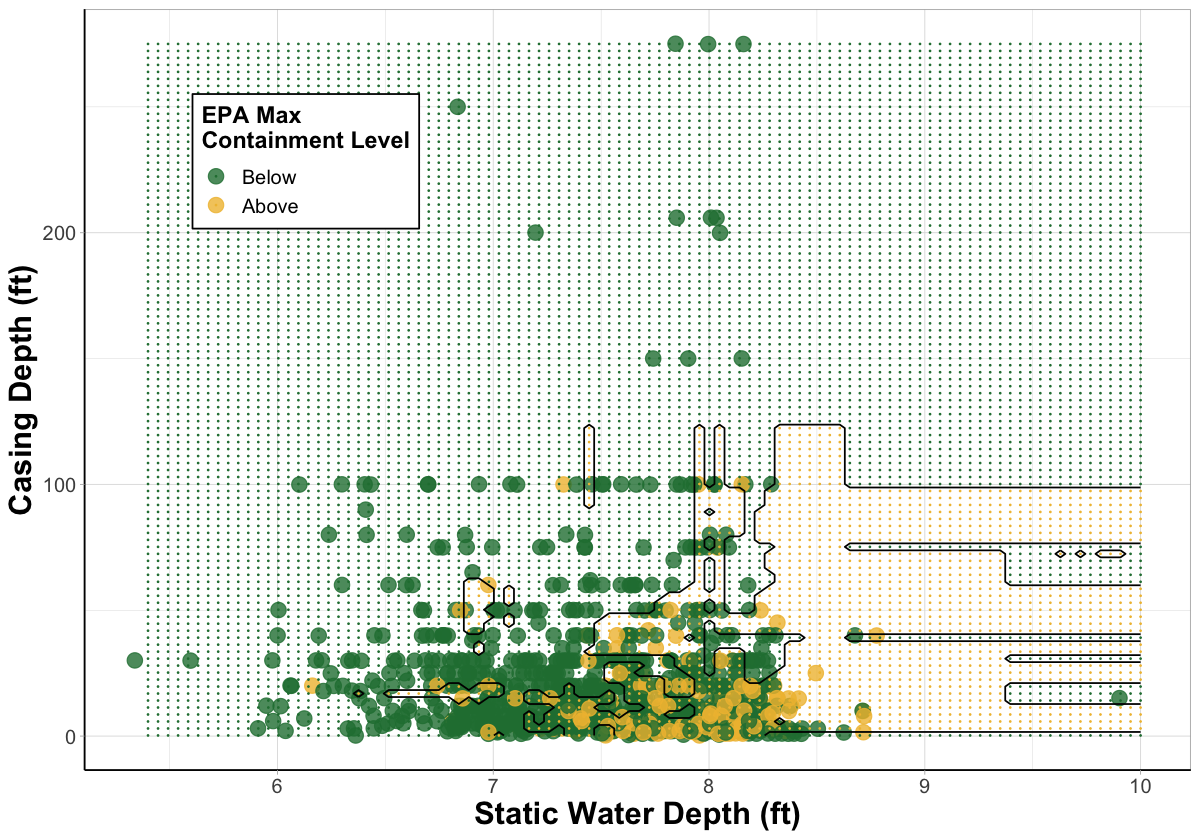

In [9]:
ggplot() +
  geom_point(data = arsenic_ten_df, aes(x = pH, y = Flow_Rate, color = Ten_Threshold),
            position = position_jitter(w = 0.1, h = 0.1), size = 4, alpha = 0.8) + 
  geom_contour(data = grid_df_rf, aes(x = pH, y = Flow_Rate, z = as.numeric(Pred_Class == "1")), 
               color = "black", breaks = 0.5) + #adds contour line
  geom_point(data = grid_df_rf, aes(x = pH, y = Flow_Rate, color = Pred_Class), 
             size = 0.1) + #shades plot

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = c(0.2,0.8), # move legend to top left corner
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  labs(x = 'Static Water Depth (ft)', y = 'Casing Depth (ft)') + #changing axis labels 

  scale_color_manual(name = "EPA Max\nContainment Level",
                      values = c(metbrewer_colors[5], metbrewer_colors[2]),
                      labels = c('Below','Above'))  #reordering